# Experiment 3: Architecture 2

Helper Functions

In [17]:
# finding accuracy 
def accuracy_score(outputs, targets, batch_size):
    out = output_to_guess(outputs, 0.5)
    numCorrect = int(torch.sum(torch.sum((out == targets), dim=1)))
    total = batch_size * 14
    return numCorrect / total


#helper function to convert a network output to a guess
def output_to_guess(output, cutoff):
    # create a temporary tensor to not override original
    temp = output.clone()
    temp[output >= 0.5] = 1
    temp[output < 0.5] = 0
    return temp

# printing performce of model
def printModelPerformance(performanceList):
    accuracy_list = []
    precision_list = []
    recall_list = []
    bcr_list = []
    for i in range(len(performanceList)):
        ac, pre, re, bcr = printSingleStat(performanceList, i)
        accuracy_list.append(ac)
        precision_list.append(pre)
        recall_list.append(re)
        bcr_list.append(bcr)
    print("Model Average Performece")
    print("Accuracy: ", round((sum(accuracy_list) / len(accuracy_list)), 3))
    print("Precision: ", round((sum(precision_list) / len(precision_list)), 3))
    print("Recall: ", round((sum(recall_list) / len(recall_list)), 3))
    print("BCR: ", round((sum(bcr_list) / len(bcr_list)),3))
    
def printSingleStat(performanceList, index):
    disease = test_loader.dataset.classes[index]
    TP = p_r_list[index]["TP"]
    FP = p_r_list[index]["FP"]
    TN = p_r_list[index]["TN"]
    FN = p_r_list[index]["FN"]
    
    Acc = (TN + TP) / (TP + TN + FP + FN)
    if ((FP + TP) == 0.0):
        Precision = 0.0
    else:
        Precision = (TP) / (FP + TP)
    if ((TP + FN) == 0.0):
        Recall = 0.0
    else:
        Recall = (TP) / (TP + FN)
    BCR = (Precision + Recall) / 2
    print("Disease: ", disease)
    print("Accuracy: ", round(Acc,5))
    print("Precision: ", round(Precision,5))
    print("Recall: ", round(Recall,5))
    print("BCR: ", round(BCR,5))
    
    return Acc, Precision, Recall, BCR

## Creating the Model

In [2]:
#TODO
from architecture2_cnn import *
from architecture2_cnn import arch2_cnn
from copy import deepcopy

# Setup: initialize the hyperparameters/variables
num_epochs = 1           # Number of full passes through the dataset
batch_size = 32        # Number of samples in each minibatch
learning_rate = 0.0001  
seed = np.random.seed(1) # Seed the random number generator for reproducibility
p_val = 0.1              # Percent of the overall dataset to reserve for validation
p_test = 0.2             # Percent of the overall dataset to reserve for testing


transform = transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])
use_cuda = torch.cuda.is_available()

if use_cuda:
    computing_device = torch.device("cuda")
    extras = {"num_workers": 1, "pin_memory": True}
    print("CUDA is supported")
else: # Otherwise, train on the CPU
    computing_device = torch.device("cpu")
    extras = False
    print("CUDA NOT supported")

# Setup the training, validation, and testing dataloaders
train_loader, val_loader, test_loader = create_split_loaders(batch_size, seed, transform=transform, 
                                                             p_val=p_val, p_test=p_test,
                                                             shuffle=True, show_sample=False, 
                                                             extras=extras)

model = arch2_cnn()
model = model.to(computing_device)
print("Model on CUDA?", next(model.parameters()).is_cuda)

criterion = torch.nn.BCELoss(size_average = True)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0)

CUDA is supported
Model on CUDA? True


## Training the Model

In [3]:
# Track the loss across training
total_loss = []
avg_minibatch_loss = []
all_valid_loss = []
train_accuracies = []
val_accuracies = []
best_model = model

# Begin training procedure
for epoch in range(num_epochs):

    N = 50
    Validation_N = 250
    N_minibatch_loss = 0.0
    N_minibatch_accuracy = 0.0

    # Get the next minibatch of images, labels for training
    for minibatch_count, (images, labels) in enumerate(train_loader, 0):
        

        # Put the minibatch data in CUDA Tensors and run on the GPU if supported
        images, labels = images.to(computing_device), labels.to(computing_device)
        
        # Zero out the stored gradient (buffer) from the previous iteration
        optimizer.zero_grad()

        # Perform the forward pass through the network and compute the loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        accuracy = accuracy_score(outputs, labels, batch_size)
        
        # Automagically compute the gradients and backpropagate the loss through the network
        loss.backward()

        # Update the weights
        optimizer.step()

        # Add this iteration's loss to the total_loss
        total_loss.append(loss.item())
        N_minibatch_loss += loss
        N_minibatch_accuracy += accuracy
        
            
        if (minibatch_count % N == 0) & (minibatch_count > 0):    
            
            # Print the loss averaged over the last N mini-batches    
            N_minibatch_loss /= N
            N_minibatch_accuracy /= N
            print('Epoch %d, average minibatch %d loss: %.3f' %
                (epoch + 1, minibatch_count, N_minibatch_loss))
            
            # Add the averaged loss over N minibatches and reset the counter
            avg_minibatch_loss.append(N_minibatch_loss)
            print("accuracy", N_minibatch_accuracy)
            train_accuracies.append(N_minibatch_accuracy)
            N_minibatch_loss = 0.0
            N_minibatch_accuracy = 0.0
            
            
        if (minibatch_count % Validation_N == 0) & (minibatch_count > 0):    
            val_loss = 0
            accuracy = 0
            with torch.no_grad(): 
                for minibatch_count, (images, labels) in enumerate(val_loader, 0):
                    # Put the minibatch data in CUDA Tensors and run on the GPU if supported
                    images, labels = images.to(computing_device), labels.to(computing_device)
                    
                    outputs = model(images)
                    val_loss += criterion(outputs, labels)
                    accuracy += accuracy_score(outputs, labels, batch_size)
                
                avgLoss = val_loss / minibatch_count
                valAccuracy = accuracy / minibatch_count
                
                print("Val Loss", avgLoss.item())
                print("Accuracy", valAccuracy)
                #checks if model is best model so far
                if (len(all_valid_loss) == 0):
                    model = deepcopy(model)
                else:
                    if (avgLoss.item() < min(all_valid_loss)):
                        model = deepcopy(model)
                all_valid_loss.append(avgLoss.item())
                val_accuracies.append(valAccuracy)

    print("Finished", epoch + 1, "epochs of training")
print("Training complete after", epoch + 1, "epochs")

Epoch 1, average minibatch 50 loss: 0.220
accuracy 0.955
Epoch 1, average minibatch 100 loss: 0.182
accuracy 0.9487500000000001
Epoch 1, average minibatch 150 loss: 0.172
accuracy 0.9517410714285713
Epoch 1, average minibatch 200 loss: 0.182
accuracy 0.9480357142857144
Epoch 1, average minibatch 250 loss: 0.186
accuracy 0.9471428571428574
Val Loss 0.18007229268550873
Accuracy 0.9490561224489792
Epoch 1, average minibatch 300 loss: 0.178
accuracy 0.9495982142857141
Epoch 1, average minibatch 350 loss: 0.188
accuracy 0.9447321428571428
Epoch 1, average minibatch 400 loss: 0.179
accuracy 0.9487946428571429
Epoch 1, average minibatch 450 loss: 0.179
accuracy 0.9483035714285714
Epoch 1, average minibatch 500 loss: 0.173
accuracy 0.9499999999999997
Val Loss 0.1799682229757309
Accuracy 0.9490306122448978
Epoch 1, average minibatch 550 loss: 0.179
accuracy 0.9486607142857143
Epoch 1, average minibatch 600 loss: 0.175
accuracy 0.9498214285714286
Epoch 1, average minibatch 650 loss: 0.179
accura

## Plotting Training

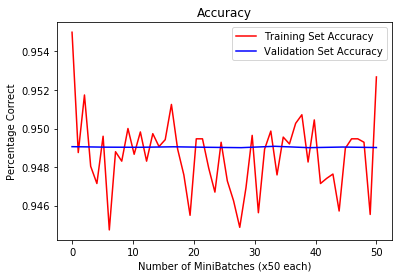

In [4]:
#Accuracy plotting

x1 = np.linspace(0,50,50)
x2 = np.linspace(0,50,10)

plt.plot(x1, train_accuracies, color = "red",label = "Training Set Accuracy")
plt.plot(x2, val_accuracies, color = "blue",label = "Validation Set Accuracy")
plt.xlabel("Number of MiniBatches (x50 each)")
plt.ylabel("Percentage Correct")
plt.title("Accuracy")
plt.legend(loc='upper right')
plt.show()

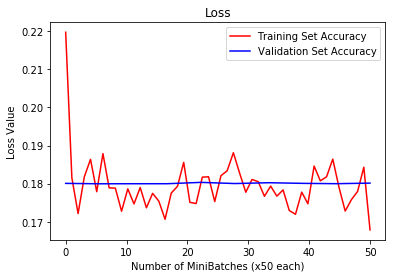

In [5]:
#Loss Function plotting

x1 = np.linspace(0,50,50)
x2 = np.linspace(0,50,10)

plt.plot(x1, avg_minibatch_loss, color = "red",label = "Training Set Accuracy")
plt.plot(x2, all_valid_loss, color = "blue",label = "Validation Set Accuracy")
plt.xlabel("Number of MiniBatches (x50 each)")
plt.ylabel("Loss Value")
plt.title("Loss")
plt.legend(loc='upper right')
plt.show()


### Convolutional Layer 1 Filters

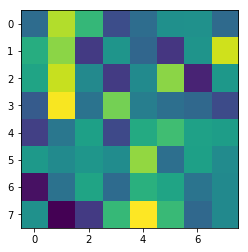

In [6]:
x = (best_model.conv1.weight.cpu().data.numpy()[3])[0]
plt.imshow(x)

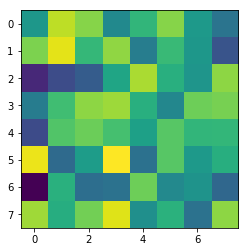

In [7]:
y = (best_model.conv1.weight.cpu().data.numpy()[2])[0]
plt.imshow(y)

### Convolutional Layer 3 Filters

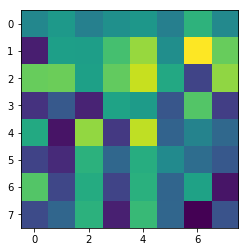

In [8]:
x = (best_model.conv3.weight.cpu().data.numpy()[3])[0]
plt.imshow(x)

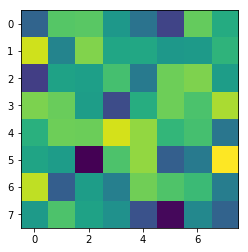

In [15]:
y = (best_model.conv3.weight.cpu().data.numpy()[2])[0]
plt.imshow(y)

### Convolutional Layer 5 Filters

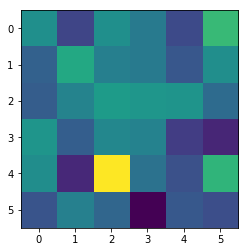

In [10]:
x = (best_model.conv5.weight.cpu().data.numpy()[3])[0]
plt.imshow(x)

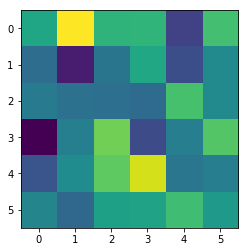

In [11]:
y = (best_model.conv5.weight.cpu().data.numpy()[0])[0]
plt.imshow(y)

## Testing Model Performance

In [12]:
#test based on best_model variable

print(len(test_loader))

p_r_list = []    #list of dictionaries, where each dictionary contains 'TP', 'FP', 'TN', 'FN'

for i in range(14):
    p_r_list.append({'TP': 0, 'FP': 0, 'TN': 0, 'FN': 0})

c_matrix = []     # confusion matrix

for i in range(14):
    c_matrix.append([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

for minibatch_count, (images, labels) in enumerate(test_loader, 0):
    
    print(minibatch_count)
    # Put the minibatch data in CUDA Tensors and run on the GPU if supported
    images, labels = images.to(computing_device), labels.to(computing_device)
    
    outputs = model(images)
    outputs = output_to_guess(outputs, 0.5)
    with torch.no_grad():
        for i in range(outputs.shape[0]):
            out = outputs.split(1)[i].tolist()[0]    # convert the outputs from tensor object to a list
            lab = labels.split(1)[i].tolist()[0]     # convert the labels from tensor object to a list

            for j in range(14):
                if out[j] == 1 and lab[j] == 1:
                    p_r_list[j]['TP'] += 1
                elif out[j] == 1 and lab[j] == 0:
                    p_r_list[j]['FP'] += 1
                elif out[j] == 0 and lab[j] == 0:
                    p_r_list[j]['TN'] += 1
                else:
                    p_r_list[j]['FN'] += 1

            for k in range(14):
                if (out[k] == 1 and lab[k] == 1) or (out[k] == 1 and lab[k] == 1):     # if output == label, put a 1 at (k,k) and zeros for everything else in that row
                    c_matrix[k][k] += 1
                if out[k] == 1 and lab[k] == 0:   # if output = 1 and label = 0, evenly distribute the error amongst activated outputs (where out[k] == 1)
                    sum_of_out = sum(out)
                    for a in range(14):
                        if out[a] == 1:
                            c_matrix[k][a] += 1/sum_of_out
                if out[k] == 0 and lab[k] == 1:   # if output = 0 and label = 1, put zeros for the row (it's not confused with other classes)
                    continue

for x in range(len(c_matrix)):
    row_sum = sum(c_matrix[x])
    if (row_sum != 0):
        for y in range(14):
            c_matrix[x][y] = c_matrix[x][y] / row_sum


    

631
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
27

Model Statistics

In [18]:
printModelPerformance(p_r_list)

Disease:  Atelectasis
Accuracy:  0.89559
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Cardiomegaly
Accuracy:  0.97235
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Effusion
Accuracy:  0.87924
Precision:  1.0
Recall:  0.00041
BCR:  0.50021
Disease:  Infiltration
Accuracy:  0.82236
Precision:  0.30172
Recall:  0.00989
BCR:  0.15581
Disease:  Mass
Accuracy:  0.94951
Precision:  0.2
Recall:  0.00098
BCR:  0.10049
Disease:  Nodule
Accuracy:  0.93984
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Pneumonia
Accuracy:  0.98731
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Pneumothorax
Accuracy:  0.95253
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Consolidation
Accuracy:  0.95887
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Edema
Accuracy:  0.97968
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Emphysema
Accuracy:  0.97656
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Fibrosis
Accuracy:  0.98419
Precision:  0.0
Recall:  0.0
BCR:  0.0
Disease:  Pleural_Thickening
Accura

Confusion Matrix

In [14]:
#print confusion matrix

for i in c_matrix:
    a = ['%.2f' % elem for elem in i]
    print(a)

['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '1.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00',